In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import torchvision
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from tqdm.autonotebook import tqdm
from torch.utils.data import Dataset, DataLoader, Subset
import torch.optim as optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
from torchvision import transforms
import os
from transformers import AutoImageProcessor, ViTModel
import torch
from datasets import load_dataset
from tqdm.notebook import tqdm
import math
import random
device='cuda' if torch.cuda.is_available() else 'cpu'
device

<ipython-input-1-30a41f0dc109>:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


'cuda'

In [2]:
MODEL_NAME="google/vit-large-patch16-224-in21k"
BATCH_SIZE=64

In [3]:
root_dir=Path("/kaggle/input/crop-bird-dataset/crop_bird_dataset/")

train_metadata_path = root_dir.parent/"train_metadata.csv"  # Path to the metadata file
train_images_dir = root_dir/"train/train/"       # Path to training images directory

val_metadata_path = root_dir.parent/"val_metadata.csv"      # Path to validation metadata file
val_images_dir = root_dir/"val/val"           # Path to validation images directory

test_images_dir = root_dir/"test/test"

In [4]:
df_train = pd.read_csv(train_metadata_path)
df_train["path"] = train_images_dir/df_train["path"]
df_train["path"] = df_train["path"].apply(lambda path: train_images_dir/path.name)

df_val = pd.read_csv(val_metadata_path)
df_val["path"] = val_images_dir/df_val["path"]
df_val["path"] = df_val["path"].apply(lambda path: val_images_dir/path.name)

df_test = pd.DataFrame(
    data = {
    "path": [path for path in test_images_dir.glob("*.jpg")]
    }
)

df_train

,path,class,class_idx
0,/kaggle/input/crop-bird-dataset/crop_bird_data...,Brandt_Cormorant,4
1,/kaggle/input/crop-bird-dataset/crop_bird_data...,Brandt_Cormorant,4
2,/kaggle/input/crop-bird-dataset/crop_bird_data...,Brandt_Cormorant,4
3,/kaggle/input/crop-bird-dataset/crop_bird_data...,Brandt_Cormorant,4
4,/kaggle/input/crop-bird-dataset/crop_bird_data...,Brandt_Cormorant,4
...,...,...,...
1077,/kaggle/input/crop-bird-dataset/crop_bird_data...,Gray_Catbird,3
1078,/kaggle/input/crop-bird-dataset/crop_bird_data...,Gray_Catbird,3
1079,/kaggle/input/crop-bird-dataset/crop_bird_data...,Gray_Catbird,3
1080,/kaggle/input/crop-bird-dataset/crop_bird_data...,Gray_Catbird,3


<BarContainer object of 20 artists>

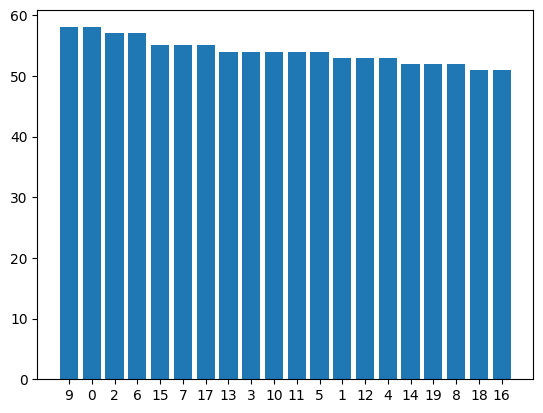

In [5]:
class_counts=df_train["class_idx"].value_counts()
plt.bar(class_counts.index.astype(str), class_counts)

In [6]:
def read_image(path, transform=None):
    if not os.path.isfile(path):  # Check if file exists
        raise FileNotFoundError(f"Image not found: {path}")
    
    image = Image.open(path).convert("RGB")  # Open as RGB
    # image = torchvision.io.read_image(path)
    if transform:
        image = transform(image)  # Apply transformations
    return image

image_processor = AutoImageProcessor.from_pretrained(MODEL_NAME, use_fast=True)

#augmentation_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
#    transforms.v2.RandomResizedCrop(size=(224, 224), scale=(0.3,0.7)),
#    transforms.ColorJitter(brightness=0.5, contrast= 0.5, saturation=0.5, hue=0.5),
#    transforms.RandomHorizontalFlip(),
#    transforms.RandomRotation(45),
#    transforms.v2.RandomZoomOut(fill=0, side_range=(1.0, 4.0)),
#    transforms.Resize((224, 224)),
#    image_processor,
#    lambda x: x["pixel_values"].squeeze(0),
#    lambda x: x.half()
#])

augmentation_transform = transforms.Compose([
    # transforms.Resize((224, 224)),
    # transforms.v2.RandomResizedCrop(size=(224, 224), scale=(0.3,0.7)),
    transforms.ColorJitter(brightness=0.2, contrast= 0.2, saturation=0.2, hue=0.0),
    transforms.RandomHorizontalFlip(),
    transforms.v2.RandomZoomOut(fill=0, side_range=(2.0, 4.0)),
    transforms.RandomRotation(90),
    transforms.Resize((224, 224)),
    image_processor,
    lambda x: x["pixel_values"].squeeze(0),
    lambda x: x.half(),
    # transforms.ToTensor()
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    image_processor,
    lambda x: x["pixel_values"].squeeze(0),
    lambda x: x.half()
])

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

In [7]:
# image=read_image("/kaggle/input/bdma-compatition/BDMA7_project_files/train_images/Brandt_Cormorant/Brandt_Cormorant_0074_22881.jpg", transform=transform)
# plt.imshow(image.squeeze(0).permute(1,2,0))

In [8]:
class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, imgs_paths, imgs_labels=None, transform=None):
        super().__init__()
        self.imgs_paths = imgs_paths
        self.imgs_labels = imgs_labels
        self.transform = transform

    def __getitem__(self, idx):
        #print(f"Loading image: {self.imgs_paths.iloc[idx]}") 
        image = read_image(self.imgs_paths.iloc[idx], self.transform)
        if self.imgs_labels is None:
            return image
        else:
            label = self.imgs_labels.iloc[idx]
            return image, label

    def __getitems__(self, indices):
        images=self.imgs_paths.iloc[indices].apply(lambda path: read_image(path, self.transform))
        if self.imgs_labels is None:
            return images.to_list()
        else:
            labels = self.imgs_labels.iloc[indices]
            return images.to_list(), labels.to_list()

    def __len__(self):
        return len(self.imgs_paths)

In [9]:
train_dataset = BirdDataset(imgs_paths = df_train["path"], imgs_labels = df_train["class_idx"], transform = augmentation_transform)
print(f"train loaded {len(train_dataset)}")
val_dataset = BirdDataset(imgs_paths = df_val["path"], imgs_labels = df_val["class_idx"], transform = transform)
print(f"val loaded {len(val_dataset)}")
test_dataset = BirdDataset(imgs_paths = df_test["path"], transform = transform)
print(f"test loaded {len(test_dataset)}")

train loaded 1082
val loaded 103
test loaded 400


In [10]:
def collate_function(batch):
    if len(batch)==2:
        x, y = batch
        return torch.stack(x), torch.tensor(y)
    else:
        return torch.stack(batch)

In [11]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers = 4, collate_fn=collate_function)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 4, collate_fn=collate_function)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers = 4, collate_fn=collate_function)

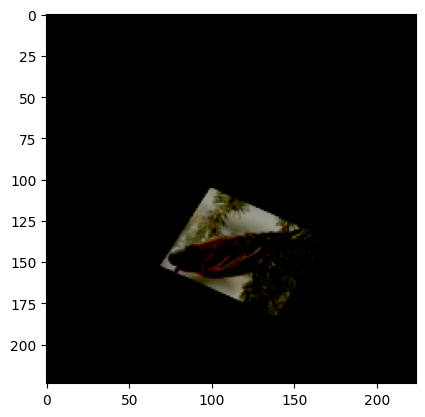

In [12]:
images, labels = next(iter(train_loader))
plt.imshow(images[0].permute(1,2,0).float())

In [13]:
num_classes = df_train["class_idx"].nunique()
print(f"num_classes = {num_classes}")

num_classes = 20


In [14]:
class ViTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(ViTClassifier, self).__init__()
        # self.vit = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
        self.vit = ViTModel.from_pretrained(MODEL_NAME)
        self.classifier = nn.Linear(self.vit.config.hidden_size, num_classes)

    def forward(self, x):
        hidden = self.vit(pixel_values=x)
        cls_token = hidden.last_hidden_state[:, 0]
        return self.classifier(cls_token)

model = ViTClassifier(num_classes).to(device)
model=model.half()

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

In [15]:
# def update_dropout(model, new_dropout):
#     for child_name, child in model.named_children():
#         # If the child is a Dropout layer, update its dropout value
#         if isinstance(child, nn.Dropout):
#             child.p = new_dropout
#         # If the child is a container/module, recursively update its children
#         else:
#             update_dropout(child, new_dropout)

# update_dropout(model, new_dropout=0.2)

In [16]:
def accuracy_fn(logits, labels):
    y_probs=F.softmax(logits, dim=-1)
    y_preds=y_probs.argmax(dim=-1)
    accuracy=(y_preds==labels).sum()/len(labels)
    return accuracy

def soft_cross_entropy(output, target, loss_lams):
    target_prob = torch.zeros_like(output)
    batch = output.shape[0]
    for k in range(batch):
        target_prob[k] = loss_lams[target[k]]
    log_like = -torch.nn.functional.log_softmax(output, dim=1)
    loss = torch.sum(torch.mul(log_like, target_prob)) / batch 
    return loss

def update_loss_lams(output, target, cur_epoch_lams, cur_epoch_cnt):
    with torch.no_grad():
        logits = torch.softmax(output, dim=1)
        sort_args = torch.argsort(logits, dim=1, descending=True)
        for k in range(output.shape[0]):
            if target[k] != sort_args[k, 0]:
                continue
            cur_epoch_lams[target[k]] += logits[k]
            cur_epoch_cnt[target[k]] += 1
    return cur_epoch_lams, cur_epoch_cnt

In [17]:
num_epochs = 100
max_lr=1e-5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=max_lr, eps=1e-04)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, epochs=num_epochs, steps_per_epoch=len(train_loader))

accuracies_g=[]
train_losses_g=[]
val_losses_g=[]
best_validation=1e9

loss_lams = torch.zeros(num_classes, num_classes, dtype=torch.float32).cuda()

for epoch in range(num_epochs):
    cur_epoch_lams = torch.zeros(num_classes, num_classes, dtype=torch.float32).cuda()
    cur_epoch_cnt = torch.zeros(num_classes, dtype=torch.float32).cuda()
    
    model.train()
    accuracies = []
    train_losses = []
    val_losses = []

    alpha=epoch/num_epochs
    for batch, labels in tqdm(train_loader):
        batch, labels = batch.to(device), labels.to(device)
        logits = model(batch)

        cur_epoch_lams, cur_epoch_cnt = update_loss_lams(logits, labels, cur_epoch_lams, cur_epoch_cnt)
        loss = (soft_cross_entropy(logits, labels, loss_lams) * alpha)  + (criterion(logits, labels) * (1-alpha))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())

    for cls in range(num_classes):
        if cur_epoch_cnt[cls].max() < 0.5:
            loss_lams[cls] = 1. / num_classes
        else:
            loss_lams[cls] = cur_epoch_lams[cls] / cur_epoch_cnt[cls]

    model.eval()
    with torch.no_grad():
        for batch, labels in tqdm(val_loader):
            batch, labels = batch.to(device), labels.to(device)
            logits = model(batch)
            loss = criterion(logits, labels)
            accuracy = accuracy_fn(logits, labels)

            accuracies.append(accuracy.item())
            val_losses.append(loss.item())

    
    accuracies_g.append(torch.tensor(accuracies).mean().item())
    train_losses_g.append(torch.tensor(train_losses).mean().item())
    val_losses_g.append(torch.tensor(val_losses).mean().item())
    print(f"Epoch: {epoch}, train_loss: {train_losses_g[-1]}, val_loss: {val_losses_g[-1]}, accuracy: {accuracies_g[-1]}")
    
    if best_validation>val_losses_g[-1]:
        torch.save(model.state_dict(), '/kaggle/working/model.pt')
        best_validation=val_losses_g[-1]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0, train_loss: 3.001838207244873, val_loss: 2.9697265625, accuracy: 0.05188301205635071


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1, train_loss: 3.009420871734619, val_loss: 2.96484375, accuracy: 0.05188301205635071


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2, train_loss: 3.0047104358673096, val_loss: 2.9580078125, accuracy: 0.06750801205635071


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3, train_loss: 2.9831111431121826, val_loss: 2.947265625, accuracy: 0.06750801205635071


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4, train_loss: 2.992302417755127, val_loss: 2.9296875, accuracy: 0.07532051205635071


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5, train_loss: 2.9596736431121826, val_loss: 2.9033203125, accuracy: 0.08313301205635071


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6, train_loss: 2.9462316036224365, val_loss: 2.8623046875, accuracy: 0.11157852411270142


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7, train_loss: 2.911994457244873, val_loss: 2.8076171875, accuracy: 0.21254006028175354


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8, train_loss: 2.8545496463775635, val_loss: 2.7294921875, accuracy: 0.30068108439445496


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9, train_loss: 2.7999770641326904, val_loss: 2.6171875, accuracy: 0.4222756624221802


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10, train_loss: 2.687614917755127, val_loss: 2.4521484375, accuracy: 0.6229968070983887


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 11, train_loss: 2.5122931003570557, val_loss: 2.2001953125, accuracy: 0.8940304517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 12, train_loss: 2.2567784786224365, val_loss: 1.87646484375, accuracy: 0.8784054517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 13, train_loss: 1.9517463445663452, val_loss: 1.4833984375, accuracy: 0.8912259340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 14, train_loss: 1.629997730255127, val_loss: 1.087890625, accuracy: 0.9068509340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 15, train_loss: 1.3149126768112183, val_loss: 0.837158203125, accuracy: 0.9296875


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 16, train_loss: 1.1113855838775635, val_loss: 0.6513671875, accuracy: 0.9246795177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 17, train_loss: 0.9636661410331726, val_loss: 0.56591796875, accuracy: 0.9090545177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 18, train_loss: 0.8928079009056091, val_loss: 0.4813232421875, accuracy: 0.953125


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 19, train_loss: 0.8154871463775635, val_loss: 0.41357421875, accuracy: 0.9403045177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 20, train_loss: 0.7167106866836548, val_loss: 0.378173828125, accuracy: 0.9274839758872986


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 21, train_loss: 0.7119427919387817, val_loss: 0.3531494140625, accuracy: 0.9559295177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 22, train_loss: 0.6750919222831726, val_loss: 0.34326171875, accuracy: 0.9609375


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 23, train_loss: 0.6041905879974365, val_loss: 0.2852783203125, accuracy: 0.9302884340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 24, train_loss: 0.6421473026275635, val_loss: 0.2939453125, accuracy: 0.9559295177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 25, train_loss: 0.628777027130127, val_loss: 0.25555419921875, accuracy: 0.96875


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 26, train_loss: 0.5837115049362183, val_loss: 0.240966796875, accuracy: 0.953125


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 27, train_loss: 0.5599580407142639, val_loss: 0.23309326171875, accuracy: 0.9609375


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 28, train_loss: 0.5324850678443909, val_loss: 0.2286376953125, accuracy: 0.9637420177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 29, train_loss: 0.531135082244873, val_loss: 0.28173828125, accuracy: 0.9074519276618958


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 30, train_loss: 0.5223747491836548, val_loss: 0.23028564453125, accuracy: 0.9481170177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 31, train_loss: 0.4815889298915863, val_loss: 0.2430419921875, accuracy: 0.9352964758872986


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 32, train_loss: 0.4877068102359772, val_loss: 0.1961669921875, accuracy: 0.96875


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 33, train_loss: 0.43273207545280457, val_loss: 0.2554931640625, accuracy: 0.9124599695205688


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 34, train_loss: 0.4562557339668274, val_loss: 0.18743896484375, accuracy: 0.9765625


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 35, train_loss: 0.43166935443878174, val_loss: 0.2193603515625, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 36, train_loss: 0.3976476192474365, val_loss: 0.1754150390625, accuracy: 0.984375


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 37, train_loss: 0.40831801295280457, val_loss: 0.20086669921875, accuracy: 0.9715545177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 38, train_loss: 0.40593406558036804, val_loss: 0.20281982421875, accuracy: 0.9559295177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 39, train_loss: 0.38264015316963196, val_loss: 0.20489501953125, accuracy: 0.96875


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 40, train_loss: 0.4175379276275635, val_loss: 0.20697021484375, accuracy: 0.9715545177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 41, train_loss: 0.4032341539859772, val_loss: 0.17352294921875, accuracy: 0.9609375


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 42, train_loss: 0.41344496607780457, val_loss: 0.221923828125, accuracy: 0.9330929517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 43, train_loss: 0.3665412366390228, val_loss: 0.1923828125, accuracy: 0.9637420177459717


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 44, train_loss: 0.35081571340560913, val_loss: 0.18505859375, accuracy: 0.9459134340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 45, train_loss: 0.3881404995918274, val_loss: 0.23846435546875, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 46, train_loss: 0.36193129420280457, val_loss: 0.28759765625, accuracy: 0.9124599695205688


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 47, train_loss: 0.373046875, val_loss: 0.2271728515625, accuracy: 0.9330929517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 48, train_loss: 0.3173397183418274, val_loss: 0.24993896484375, accuracy: 0.9381009340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 49, train_loss: 0.34699562191963196, val_loss: 0.17694091796875, accuracy: 0.9509214758872986


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 50, train_loss: 0.31883329153060913, val_loss: 0.2403564453125, accuracy: 0.9174679517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 51, train_loss: 0.3548943102359772, val_loss: 0.2872314453125, accuracy: 0.8918269276618958


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 52, train_loss: 0.32971909642219543, val_loss: 0.20849609375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 53, train_loss: 0.3270622789859772, val_loss: 0.22760009765625, accuracy: 0.9302884340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 54, train_loss: 0.33190199732780457, val_loss: 0.1973876953125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 55, train_loss: 0.33033663034439087, val_loss: 0.2474365234375, accuracy: 0.9381009340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 56, train_loss: 0.32640165090560913, val_loss: 0.21942138671875, accuracy: 0.9381009340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 57, train_loss: 0.3360954821109772, val_loss: 0.22296142578125, accuracy: 0.9381009340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 58, train_loss: 0.3168586194515228, val_loss: 0.2811279296875, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 59, train_loss: 0.31869685649871826, val_loss: 0.243408203125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 60, train_loss: 0.30587947368621826, val_loss: 0.26641845703125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 61, train_loss: 0.32384535670280457, val_loss: 0.19927978515625, accuracy: 0.9381009340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 62, train_loss: 0.3345301151275635, val_loss: 0.268310546875, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 63, train_loss: 0.30300724506378174, val_loss: 0.2117919921875, accuracy: 0.9381009340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 64, train_loss: 0.30451515316963196, val_loss: 0.2103271484375, accuracy: 0.9381009340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 65, train_loss: 0.31702378392219543, val_loss: 0.23321533203125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 66, train_loss: 0.32736384868621826, val_loss: 0.226318359375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 67, train_loss: 0.3187040388584137, val_loss: 0.22637939453125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 68, train_loss: 0.31271541118621826, val_loss: 0.2562255859375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 69, train_loss: 0.3316004276275635, val_loss: 0.22845458984375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 70, train_loss: 0.3102452754974365, val_loss: 0.2119140625, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 71, train_loss: 0.304443359375, val_loss: 0.20654296875, accuracy: 0.9381009340286255


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 72, train_loss: 0.3105037808418274, val_loss: 0.22564697265625, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 73, train_loss: 0.330810546875, val_loss: 0.23138427734375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 74, train_loss: 0.3523954451084137, val_loss: 0.24407958984375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 75, train_loss: 0.33371150493621826, val_loss: 0.24005126953125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 76, train_loss: 0.33924058079719543, val_loss: 0.22613525390625, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 77, train_loss: 0.33493220806121826, val_loss: 0.22161865234375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 78, train_loss: 0.3190056383609772, val_loss: 0.20977783203125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 79, train_loss: 0.33840763568878174, val_loss: 0.2083740234375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 80, train_loss: 0.3663545548915863, val_loss: 0.2078857421875, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 81, train_loss: 0.3506433963775635, val_loss: 0.20855712890625, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 82, train_loss: 0.34412339329719543, val_loss: 0.20831298828125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 83, train_loss: 0.34870460629463196, val_loss: 0.20965576171875, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 84, train_loss: 0.37468406558036804, val_loss: 0.21380615234375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 85, train_loss: 0.35348689556121826, val_loss: 0.21612548828125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 86, train_loss: 0.34410902857780457, val_loss: 0.21734619140625, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 87, train_loss: 0.3538028597831726, val_loss: 0.21826171875, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 88, train_loss: 0.36656996607780457, val_loss: 0.21807861328125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 89, train_loss: 0.35466453433036804, val_loss: 0.21783447265625, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 90, train_loss: 0.35378849506378174, val_loss: 0.21783447265625, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 91, train_loss: 0.3831571638584137, val_loss: 0.2177734375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 92, train_loss: 0.3634248673915863, val_loss: 0.2178955078125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 93, train_loss: 0.39572322368621826, val_loss: 0.2177734375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 94, train_loss: 0.408935546875, val_loss: 0.2177734375, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 95, train_loss: 0.37854722142219543, val_loss: 0.21783447265625, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 96, train_loss: 0.3552677035331726, val_loss: 0.2178955078125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 97, train_loss: 0.37731215357780457, val_loss: 0.2178955078125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 98, train_loss: 0.4134306013584137, val_loss: 0.2178955078125, accuracy: 0.9252804517745972


  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 99, train_loss: 0.39441636204719543, val_loss: 0.2178955078125, accuracy: 0.9252804517745972


In [18]:
# model.load_state_dict(torch.load('/kaggle/input/vit_ols_aug/pytorch/default/1/model.pt'))

In [19]:
all_preds=[]

model.eval()
with torch.no_grad():
    for batch in tqdm(test_loader):
        batch = batch.to(device)
        logits = model(batch)
        y_probs=F.softmax(logits, dim=-1)
        y_preds=y_probs.argmax(dim=-1)
        all_preds.append(y_preds)

all_preds=torch.cat(all_preds)

  0%|          | 0/7 [00:00<?, ?it/s]

In [20]:
df_submit=df_test.copy()
df_submit["class_idx"]=all_preds.cpu().numpy()
df_submit["path"]=df_submit["path"].apply(lambda path: Path(path).name)
df_submit.to_csv("vit_model_large_half_smooth_labels_augmentation.csv",index=False)
df_submit

,path,class_idx
0,e17fb45d-08a6-412a-8436-c68bca97a2b0.jpg,11
1,da82c136-bbca-4f69-9e97-2c0edf75e223.jpg,7
2,beb3a70d-c13f-47aa-aaed-2834488a2665.jpg,13
3,2c25579e-d68d-46fa-a6fe-35dc7b5ddbda.jpg,8
4,8ba3fd3a-09b1-40f2-9d64-e3e6c61c7c3b.jpg,15
...,...,...
395,30b4b83f-1559-464f-a729-cf8679f73077.jpg,11
396,4989cca6-982c-4f7d-a531-50334a3dd5b3.jpg,19
397,860a92e8-8c06-4e38-83d4-05d07d0baacf.jpg,0
398,1d9c405f-b193-4034-9744-1ce5c2778296.jpg,1
